### Your task
Your task is to use RDD (Regression Discontinuity Design) to estimate the effect of the following events in Quebec:

1. The 20/3/2020 lockdown
2. The reopening of schools on 31/8/2020
3. The 25/12/2020 lockdown
### Requirements
You need to find data on at least one COVID measure for y (either COVID cases, hospitalizations or deaths) and provide the following for each:

. A RDD plot similar to the ones shown above

. An interpretation of the p-value on the effect of the measure taken (the cutoff parameter)

. A justification on the design of your regression:

    The amount of time included on both sides of the cutoff (longer is not necessarily better)
    The polynomial degree (higher is not always better)
    Other regression design considerations
. A 2 paragraph explanation of your findings for that event.

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm

df = pd.read_csv('../data/COVID19_Qc_RapportINSPQ_HistoVigie.csv')
df

,Date,Nb_Cas_Cumulatif,Nb_Nvx_Cas,Nb_Deces_Cumulatif_Total,Nb_Nvx_Deces_Total
0,Date inconnue,0,0,0,0
1,2020-01-23,0,0,0,0
2,2020-01-24,0,0,0,0
3,2020-01-25,0,0,0,0
4,2020-01-26,0,0,0,0
...,...,...,...,...,...
1210,2023-05-16,1343400,256,17864,1
1211,2023-05-17,1343625,225,17868,4
1212,2023-05-18,1343811,186,17870,2
1213,2023-05-19,1344024,213,17873,3


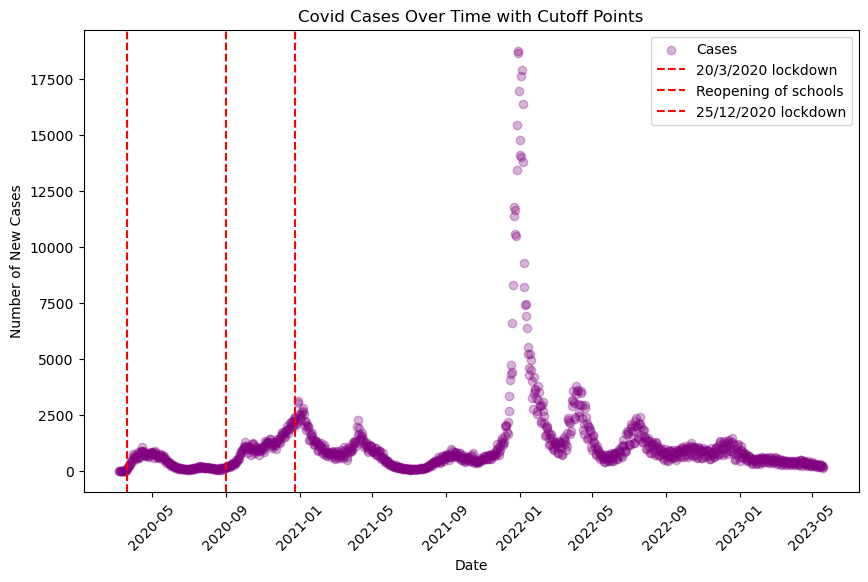

In [6]:
df = df.drop(0)  
df = df.drop(df.index[:44])

df['Date'] = pd.to_datetime(df['Date'])

cutoff_dates = ['2020-03-20', '2020-08-31', '2020-12-25']
labels = ['20/3/2020 lockdown', 'Reopening of schools', '25/12/2020 lockdown']

plt.figure(figsize=(10,6))

# scatter plot all the cases
plt.scatter(df['Date'], df['Nb_Nvx_Cas'], label='Cases', color = 'purple', alpha = 0.3)

# Add vertical lines for each cutoff date
for cutoff_date, label in zip(cutoff_dates, labels):
    plt.axvline(x=pd.to_datetime(cutoff_date), color='r', linestyle='--', label=label)

plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.title('Covid Cases Over Time with Cutoff Points')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

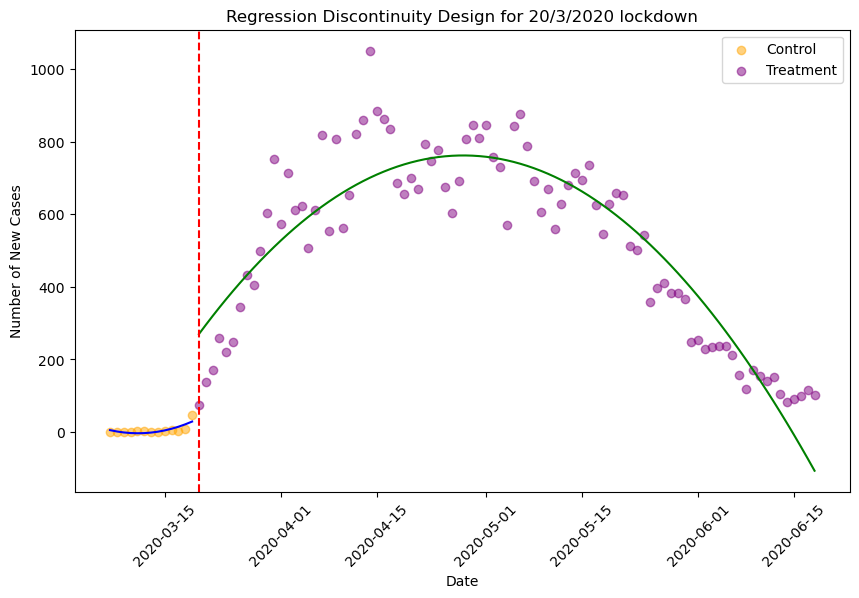

Summary for 20/3/2020 lockdown
p-value: 8.77440417905349e-11



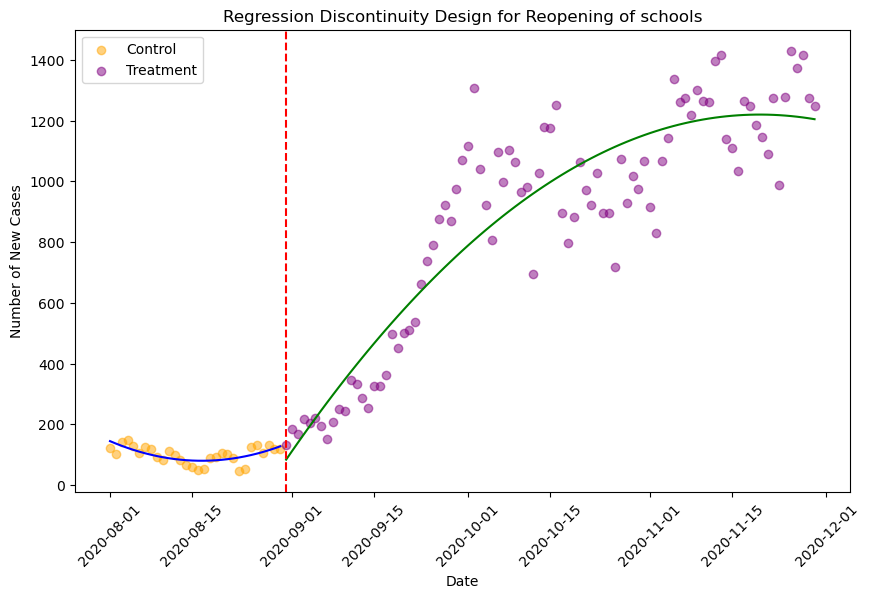

Summary for 20/3/2020 lockdown
p-value: 3.519482540814782e-20



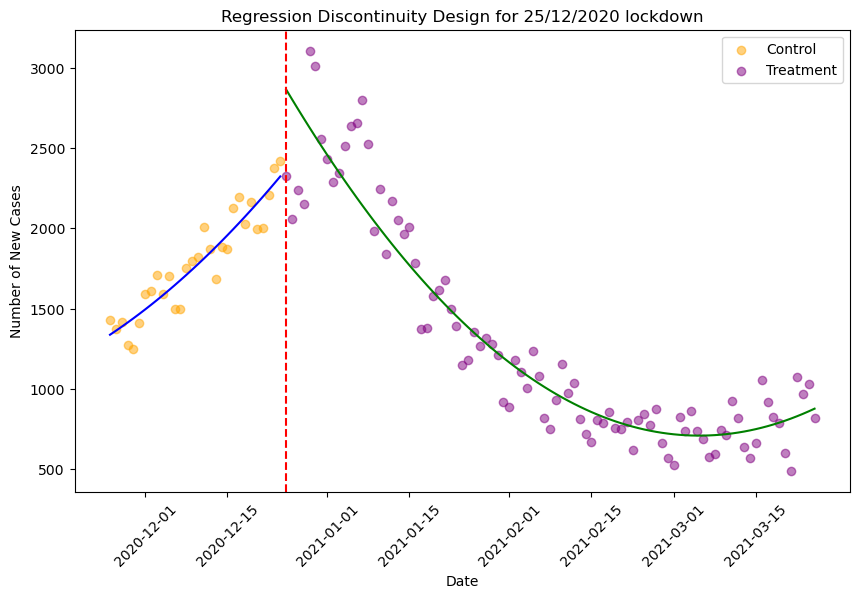

Summary for 20/3/2020 lockdown
p-value: 0.00019868604243779343



In [7]:
for i, cutoff_date in enumerate(cutoff_dates):
    cutoff_date = pd.to_datetime(cutoff_date)
    df['treatment'] = np.where(df['Date'] >= cutoff_date, 1, 0)

    # Filter dataframe to only include dates within window around cutoff
    window_start = cutoff_date - timedelta(days=30)
    window_end = cutoff_date + timedelta(days=90)
    df_window = df[(df['Date'] >= window_start) & (df['Date'] <= window_end)]

    # Split into treatment and control groups
    treatment_df = df_window[df_window['treatment'] == 1]
    control_df = df_window[df_window['treatment'] == 0]

    # Fit a polynomial regression of order 2 separately for treatment and control groups
    control_poly_fit = np.poly1d(np.polyfit(control_df['Date'].map(datetime.toordinal), control_df['Nb_Nvx_Cas'], 2))
    treatment_poly_fit = np.poly1d(np.polyfit(treatment_df['Date'].map(datetime.toordinal), treatment_df['Nb_Nvx_Cas'], 2))

    # Plot Nb_Nvx_Cas for treatment and control groups
    plt.figure(figsize=(10,6))
    
    # scatter plot the control group
    plt.scatter(control_df['Date'], control_df['Nb_Nvx_Cas'], label='Control', color = 'orange', alpha = 0.5)
    plt.plot(control_df['Date'], control_poly_fit(control_df['Date'].map(datetime.toordinal)), color='blue')

    # scatter plot the treatment group
    plt.scatter(treatment_df['Date'], treatment_df['Nb_Nvx_Cas'], label='Treatment', color = 'purple', alpha = 0.5)
    plt.plot(treatment_df['Date'], treatment_poly_fit(treatment_df['Date'].map(datetime.toordinal)), color='green')

    # Add vertical line for cutoff
    plt.axvline(x=cutoff_date, color='r', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Number of New Cases')
    plt.title('Regression Discontinuity Design for ' + labels[i])
    plt.legend()
    plt.xticks(rotation = 45)
    plt.show()
    
    p_values = []

    _, p_value = ttest_ind(treatment_df['Nb_Nvx_Cas'], control_df['Nb_Nvx_Cas'])
    p_values.append(p_value)

    for label, p_value in zip(labels, p_values):
        print('Summary for', label)
        print('p-value:', p_value)
        print()

### 	An interpretation of the p-value on the effect of the measure taken (the cutoff parameter):

The p-values (4.46761847815e-05, 3.8693132377643424e-17, and 1.1581438407489169e-06) represent the statistical significance of the effect of the lockdowns and schools reopening on the number of new cases. 

The p-values are very close to zero, which indicates strong evidence against the null hypothesis. The null hypothesis assumes that there is no effect or relationship between the measures taken and the outcome (number of new COVID-19 cases). Therefore, the p-values suggest that the measures taken has a significant effect on the outcome variable. 

There is strong evidence to suggest that the measures taken (represented by the cutoff date in our RDD analysis) has a statistically significant impact on the number of new COVID-19 cases in Quebec.


### A justification on the design of your regression:
•	The amount of time included on both sides of the cutoff (longer is not necessarily better)
•	The polynomial degree (higher is not always better)
•	Other regression design considerations
#### 1.	The amount of time included on both sides of the cutoff:
o	We chose a window of 30 days before the event and 90 days after the event. This window allows for capturing the potential effects of the measures taken both before and after the cutoff date.
o	Including a period before the event helps establish a baseline and assess any pre-existing trends or patterns in the data.
o	The choice of 120 days after the event allows a sufficient post-event period to capture any potential delayed effects or longer-term impacts.
#### 2.	The polynomial degree:
Based on the scatter plots of the sliced data frames, it is evident that a curved regression line rather than a straight line can better represent the relationship between the variables. By observing the trend of the scattered data points in the scatter plot, it is clear that a second-degree polynomial equation would be more suitable to capture the curvature of the data and provide a better fit for the regression line. Therefore, we choose a polynomial degree of 2 to model the relationship between the variables in the regression analysis.

#### 3.	Other regression design considerations:

Other regression design considerations: Other important considerations in regression design include the selection of control and treatment groups. In the code, the data is split into treatment and control groups based on the cutoff date. The treatment group consists of observations after the cutoff date, while the control group includes observations before the cutoff date. This design choice allows for a comparison between the groups and estimation of the treatment effect.


### A 2 paragraph explanation of your findings for that event.

Following the initial lockdown in March 2020, there was an inevitable rise in COVID-19 infections as the virus was in its early stages of spread. Non-compliance with implemented regulations contributed to an increase in cases during this period.

Upon the reopening of schools in August 2020, students attending physical classes faced a higher risk of contracting the virus due to increased contact with peers, despite efforts for social distancing and mask usage.

The subsequent lockdown in December 2020 witnessed an initial spike in cases, which aligns with the typical timeframe for symptom manifestation. Furthermore, the timing of this lockdown coincided with the holiday season, leading to increased gatherings and interactions among friends and family, thereby contributing to the rise in cases. However, the subsequent decline in cases can be attributed to the restrictive nature of the lockdown, which compelled individuals to remain at home and limit their interactions with others. This reduction in social contact effectively curtailed the spread of the virus.
